In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'
variables = ['NO3','SiO3','PO4']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
path

'/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'

### get monthly data and immediately convert it to annual

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    #ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
%%time

ds_ann = xr.Dataset()

#for year in np.arange(1997,2006,1):
for year in np.arange(1997,2018,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")

1997
NO3
SiO3
PO4
1998
NO3
SiO3
PO4
1999
NO3
SiO3
PO4
2000
NO3
SiO3
PO4
2001
NO3
SiO3
PO4
2002
NO3
SiO3
PO4
2003
NO3
SiO3
PO4
2004
NO3
SiO3
PO4
2005
NO3
SiO3
PO4
2006
NO3
SiO3
PO4
2007
NO3
SiO3
PO4
2008
NO3
SiO3
PO4
2009
NO3
SiO3
PO4
2010
NO3
SiO3
PO4
2011
NO3
SiO3
PO4
2012
NO3
SiO3
PO4
2013
NO3
SiO3
PO4
2014
NO3
SiO3
PO4
2015
NO3
SiO3
PO4
2016
NO3
SiO3
PO4
2017
NO3
SiO3
PO4
CPU times: user 9min 36s, sys: 1min 8s, total: 10min 45s
Wall time: 11min 39s


In [5]:
ds_ann

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 21)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon, time
Data variables:
    PO4      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    dz       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    KMT      (time, nlat, nlon) float64 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SiO3     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    NO3      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

### spin up some dask to make the processing faster

In [6]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [7]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [8]:
client

Client Scheduler: tcp://10.12.205.14:45272 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

### Make a mean over time

In [10]:
ds = ds_ann.mean(dim='time')

In [11]:
#ds = ds.compute()

In [12]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Data variables:
    PO4      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz       float32 dask.array<chunksize=(), meta=np.ndarray>
    KMT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SiO3     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    NO3      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

### Get WOA data

In [13]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_x0.1POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [14]:
ds_woa = ds_woa.isel(z_t=0)

In [15]:
#ds_woa['z_t'] = ds.z_t

NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3

In [16]:
ds.NO3

<xarray.DataArray 'NO3' (nlat: 2400, nlon: 3600)>
dask.array<mean_agg-aggregate, shape=(2400, 3600), dtype=float32, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Nitrate
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

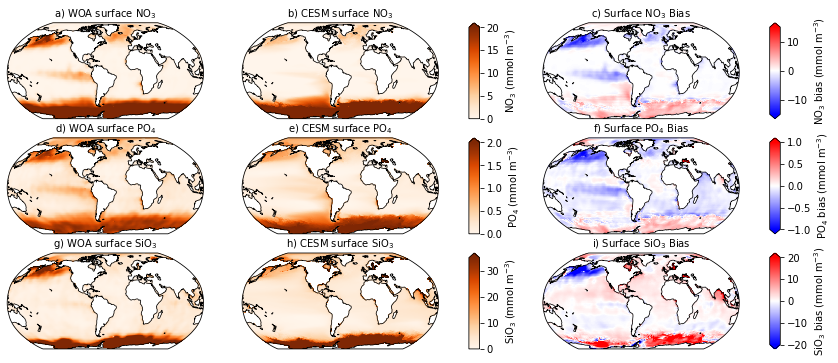

In [17]:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(nrows=3, ncols=6, width_ratios=(1, 1, 0.05, 0.05, 1, 0.05))

prj = ccrs.Robinson(central_longitude=305.0)

ax_no3_woa = plt.subplot(gs[0, 0], projection=prj)
ax_no3_cesm = plt.subplot(gs[0, 1], projection=prj)
cax_no3 = plt.subplot(gs[0, 2])
ax_no3_diff = plt.subplot(gs[0, 4], projection=prj)
cax_no3_diff = plt.subplot(gs[0, 5])

ax_po4_woa = plt.subplot(gs[1, 0], projection=prj)
ax_po4_cesm = plt.subplot(gs[1, 1], projection=prj)
cax_po4 = plt.subplot(gs[1, 2])
ax_po4_diff = plt.subplot(gs[1, 4], projection=prj)
cax_po4_diff = plt.subplot(gs[1, 5])

ax_si_woa = plt.subplot(gs[2, 0], projection=prj)
ax_si_cesm = plt.subplot(gs[2, 1], projection=prj)
cax_si = plt.subplot(gs[2, 2])
ax_si_diff = plt.subplot(gs[2, 4], projection=prj)
cax_si_diff = plt.subplot(gs[2, 5])


### NO3 row
ax_no3_woa.set_title('a) WOA surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3)
pc1=ax_no3_woa.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_woa.coastlines('110m',linewidth=0.75)

ax_no3_cesm.set_title('b) CESM surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.NO3)
pc1=ax_no3_cesm.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_cesm.coastlines('110m',linewidth=0.75)

cb_no3 = plt.colorbar(pc1, cax=cax_no3,extend='max', 
                      label='NO$_3$ (mmol m$^{-3}$)')

ax_no3_diff.set_title('c) Surface NO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, NO3_diff)
pc1=ax_no3_diff.pcolormesh(lon, lat,field, vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_no3_diff.coastlines('110m',linewidth=0.75)

cb_no3_diff = plt.colorbar(pc1, cax=cax_no3_diff,extend='both', 
                      label='NO$_3$ bias (mmol m$^{-3}$)')


### PO4 row
ax_po4_woa.set_title('d) WOA surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.PO4)
pc1=ax_po4_woa.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_woa.coastlines('110m',linewidth=0.75)

ax_po4_cesm.set_title('e) CESM surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.PO4)
pc1=ax_po4_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_cesm.coastlines('110m',linewidth=0.75)

cb_po4 = plt.colorbar(pc1, cax=cax_po4,extend='max', 
                      label='PO$_4$ (mmol m$^{-3}$)')

ax_po4_diff.set_title('f) Surface PO$_4$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, PO4_diff)
pc1=ax_po4_diff.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_po4_diff.coastlines('110m',linewidth=0.75)

cb_po4_diff = plt.colorbar(pc1, cax=cax_po4_diff,extend='both', 
                      label='PO$_4$ bias (mmol m$^{-3}$)')


### SiO3 row
ax_si_woa.set_title('g) WOA surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.SiO3)
pc1=ax_si_woa.pcolormesh(lon, lat,field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_woa.coastlines('110m',linewidth=0.75)

ax_si_cesm.set_title('h) CESM surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.SiO3)
pc1=ax_si_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_cesm.coastlines('110m',linewidth=0.75)

cb_si = plt.colorbar(pc1, cax=cax_si,extend='max', 
                      label='SiO$_3$ (mmol m$^{-3}$)')

ax_si_diff.set_title('i) Surface SiO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, SiO3_diff)
pc1=ax_si_diff.pcolormesh(lon, lat, field, vmin=-20, vmax=20, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_si_diff.coastlines('110m',linewidth=0.75)

cb_si_diff = plt.colorbar(pc1, cax=cax_si_diff,extend='both', 
                      label='SiO$_3$ bias (mmol m$^{-3}$)')

fig.savefig('/glade/work/kristenk/figs/Fig2_nuts_validation.png', bbox_inches='tight', dpi=300, format='png');